<h1> Aspect-level Sentiment Analysis

<h4> Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk

import warnings
warnings.filterwarnings('ignore')

from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

<h4> Loading pre-processed dataset

In [2]:
df = pd.read_csv('../data/(C) sentence_level_final_data.csv')

<h4> Average Sentiments towards Different Airline Brands

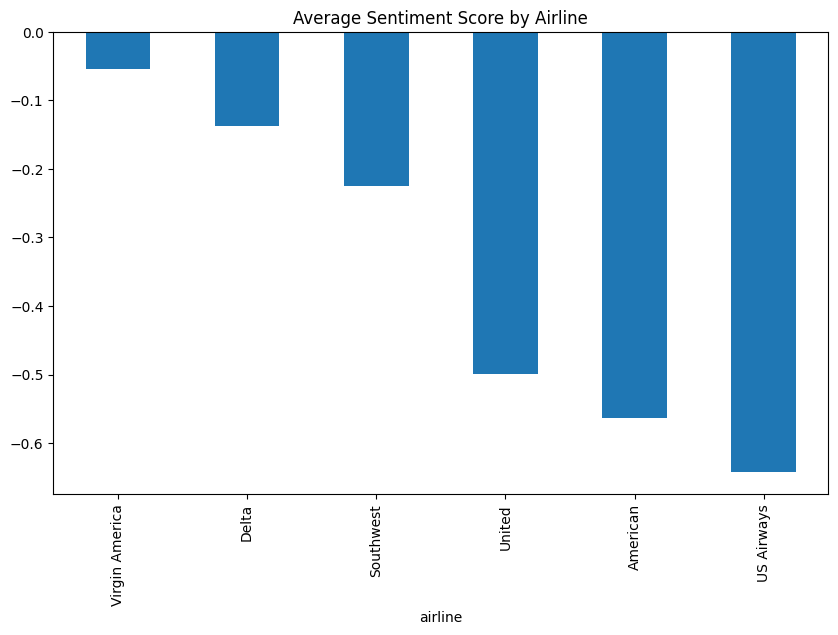

In [3]:
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
df['ensemble_sentiment_score'] = df['ensemble_sentiment'].map(sentiment_mapping)

average_sentiment = df.groupby('airline')['ensemble_sentiment_score'].mean()
average_sentiment_sorted = average_sentiment.sort_values(ascending=False)
average_sentiment_sorted.plot(kind='bar', figsize=(10, 6))
plt.title('Average Sentiment Score by Airline')
plt.show()

<h4> Negative Topic Modelling

<h4> Latent Dirichlet Allocation (LDA)

In [4]:
def compute_coherence_scores(corpus, dictionary, tokenized_texts, topic_nums):
    coherence_scores = []
    for num_topics in topic_nums:
        lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=0)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()
        coherence_scores.append(coherence_score)
    return coherence_scores

In [5]:
negative_tweets = df[df['ensemble_sentiment'] == 'negative']['tweet']
tokenized_negative_tweets = [word_tokenize(tweet) for tweet in negative_tweets]
num_topics = range(3, 15)

dictionary_bow_1gram = corpora.Dictionary(tokenized_negative_tweets)
corpus_bow_1gram = [dictionary_bow_1gram.doc2bow(text) for text in tokenized_negative_tweets]
coherence_scores_bow_1gram = compute_coherence_scores(corpus_bow_1gram, dictionary_bow_1gram, tokenized_negative_tweets, num_topics)

bow_2gram_model = Phrases(tokenized_negative_tweets, min_count=1, threshold=1)
bow_2gram_phraser = Phraser(bow_2gram_model)
bow_2gram_texts = [bow_2gram_phraser[text] for text in tokenized_negative_tweets]
dictionary_bow_2gram = corpora.Dictionary(bow_2gram_texts)
corpus_bow_2gram = [dictionary_bow_2gram.doc2bow(text) for text in bow_2gram_texts]
coherence_scores_bow_2gram = compute_coherence_scores(corpus_bow_2gram, dictionary_bow_2gram, bow_2gram_texts, num_topics)

bow_3gram_model = Phrases(bow_2gram_texts, min_count=1, threshold=1)
bow_3gram_phraser = Phraser(bow_3gram_model)
bow_3gram_texts = [bow_3gram_phraser[text] for text in bow_2gram_texts]
dictionary_bow_3gram = corpora.Dictionary(bow_3gram_texts)
corpus_bow_3gram = [dictionary_bow_3gram.doc2bow(text) for text in bow_3gram_texts]
coherence_scores_bow_3gram = compute_coherence_scores(corpus_bow_3gram, dictionary_bow_3gram, bow_3gram_texts, num_topics)

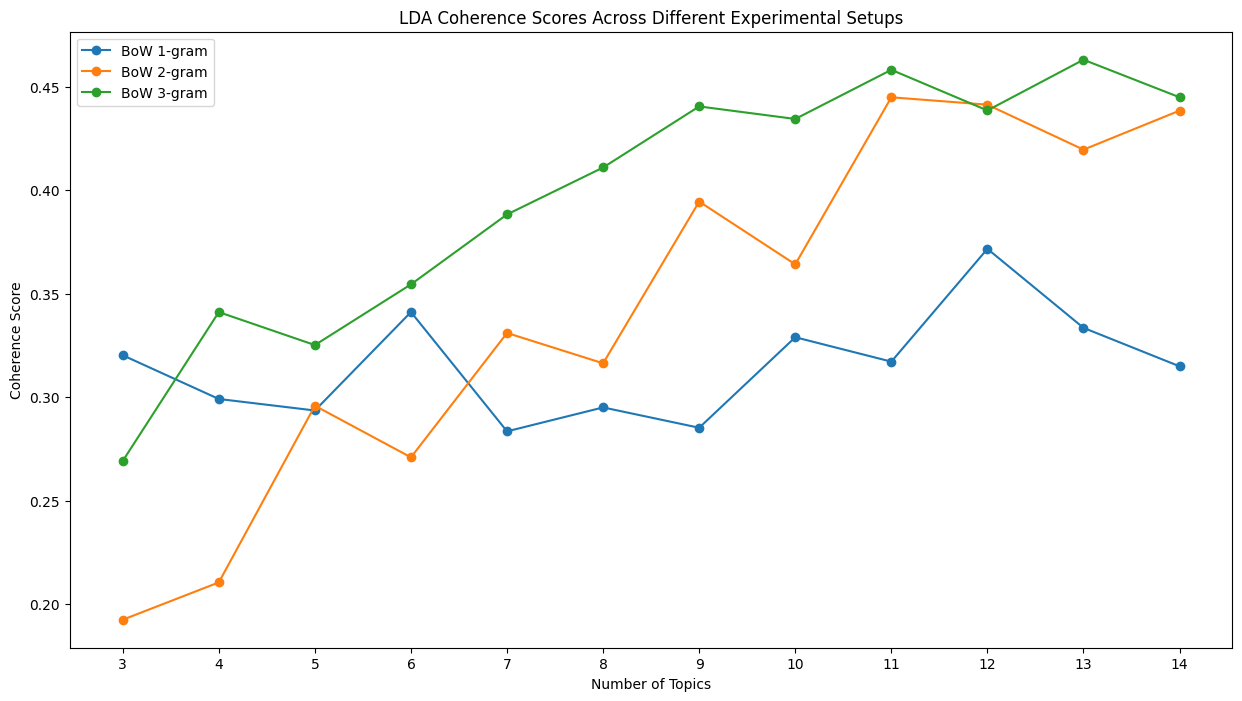

In [6]:
plt.figure(figsize=(15, 8))

plt.plot(num_topics, coherence_scores_bow_1gram, marker='o', label='BoW 1-gram')
plt.plot(num_topics, coherence_scores_bow_2gram, marker='o', label='BoW 2-gram')
plt.plot(num_topics, coherence_scores_bow_3gram, marker='o', label='BoW 3-gram')

plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics)
plt.title('LDA Coherence Scores Across Different Experimental Setups')
plt.legend()
plt.show()

In [9]:
lda_model = models.LdaModel(corpus_bow_3gram, num_topics=11, id2word=dictionary_bow_3gram, passes=15, random_state=0)
topics = lda_model.print_topics(num_words=5)
for topic_num, topic in enumerate(topics):
    print(f"Topic {topic_num + 1}: {topic[1]}")

Topic 1: 0.022*"americanair" + 0.012*"usairways_americanair" + 0.010*"usairways" + 0.010*"southwestair" + 0.009*"phone"
Topic 2: 0.014*"cancelled_flightled" + 0.010*"united" + 0.008*"southwestair" + 0.008*"w" + 0.007*"americanair_cancelled"
Topic 3: 0.036*"americanair" + 0.014*"usairways" + 0.011*"hold" + 0.008*"southwestair" + 0.008*"line"
Topic 4: 0.017*"united" + 0.014*"usairways" + 0.009*"tomorrow" + 0.008*"jetblue" + 0.008*"dfw"
Topic 5: 0.094*"americanair" + 0.013*"call" + 0.010*"usairways" + 0.007*"answer" + 0.006*"going"
Topic 6: 0.038*"americanair" + 0.028*"jetblue" + 0.009*"u" + 0.008*"delay" + 0.007*"hold_hour"
Topic 7: 0.023*"usairways" + 0.022*"southwestair" + 0.015*"customer_service" + 0.007*"americanair_im" + 0.006*"hour"
Topic 8: 0.038*"americanair" + 0.010*"united" + 0.008*"usairways" + 0.008*"even" + 0.008*"hang"
Topic 9: 0.012*"usairways" + 0.010*"please_help" + 0.010*"americanair_need" + 0.010*"bag" + 0.008*"delayed"
Topic 10: 0.011*"problem" + 0.011*"help" + 0.007*